In [2]:
# Basic imports :
import pandas as pd
import numpy as np

# Visualization :
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Turn off warning
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../datasets/raw/weather_base_df.csv')

In [6]:
df['date'] = pd.to_datetime(df['date'])

## 2°/ Pre-processing :

In [7]:
missing_values = (df['TM'].groupby(df['date'].dt.year)
                  .apply(lambda x: round(x.isnull()
                         .mean() * 100, 2)))

# Get the number of stations in activity each year
stations_in_activity = df['NUM_POSTE'].groupby(df['date'].dt.year).nunique()

# Create a dataframe to hold the missing values and stations in activity
missing_values_df = pd.DataFrame({'missing_values': missing_values, 'stations_in_activity': stations_in_activity})

missing_values_df

,missing_values,stations_in_activity
date,,
2013,64.63,3897
2014,64.51,3841
2015,64.35,3764
2016,63.54,3685
2017,62.60,3559
2018,60.44,3410
2019,53.84,3236
2020,48.30,3121
2021,27.34,2435


In [8]:
#plt.figure(figsize=(12, 6))
#sns.barplot(x=missing_values.index, y=missing_values.values)
#plt.xticks(rotation=90)
#plt.title('Percentage of Missing Values by Year in FMM')
#plt.xlabel('Year')
#plt.ylabel('Percentage of Missing Values')
#plt.show()

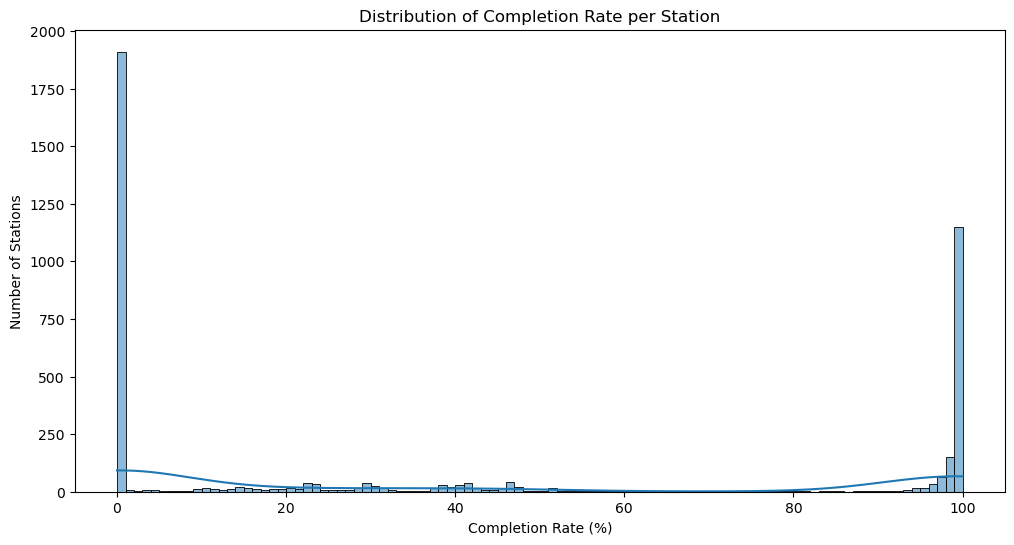

In [9]:
# Display the distribution of completion rate per station
completion_rate = df.groupby('NUM_POSTE')['TM'].apply(lambda x: x.notnull().mean() * 100)
plt.figure(figsize=(12, 6))
sns.histplot(completion_rate, bins=100, kde=True)
plt.title('Distribution of Completion Rate per Station')
plt.xlabel('Completion Rate (%)')
plt.ylabel('Number of Stations')
plt.show()

### 2.1°/ Time series :

In [10]:
# Pipeline Time Series data
id_col = ['date', 'dept_numb', 'dept_name', 'NUM_POSTE']

# Filter by active station
completion_rate = df.groupby('NUM_POSTE')['TM'].apply(lambda x: x.notnull().mean() * 100)
df_filtered = df[id_col + ['TM']]
df_filtered = df[df['NUM_POSTE'].map(completion_rate) >= 80.0]

# Aggregate the mean between station by dept
df_agg = df_filtered.groupby(id_col[:3])['TM'].mean().reset_index()

In [11]:
PACA = [4, 6, 13, 83, 84]

# PACA is the best region (No NaN value)
df_clean = df_agg.loc[df_agg['dept_numb'].isin(PACA)]
df_clean.head(10)

,date,dept_numb,dept_name,TM
3,2013-01-01,4,Alpes-de-Haute-Provence,0.515385
5,2013-01-01,6,Alpes-Maritimes,3.134483
12,2013-01-01,13,Bouches-du-Rhône,7.787500
82,2013-01-01,83,Var,6.626923
83,2013-01-01,84,Vaucluse,5.914286
97,2013-01-02,4,Alpes-de-Haute-Provence,1.084615
99,2013-01-02,6,Alpes-Maritimes,4.848276
106,2013-01-02,13,Bouches-du-Rhône,6.006250
176,2013-01-02,83,Var,5.738462
177,2013-01-02,84,Vaucluse,4.707143


In [12]:
# Check NaN Value
missing_values = (df_clean['TM'].groupby(df_clean['dept_name'])
                  .apply(lambda x: round(x.isnull()
                         .mean() * 100, 2)))

# Create a dataframe to hold the missing values and stations in activity
missing_values_df = pd.DataFrame({'missing_values': missing_values})

missing_values_df

,missing_values
dept_name,
Alpes-Maritimes,0.0
Alpes-de-Haute-Provence,0.0
Bouches-du-Rhône,0.0
Var,0.0
Vaucluse,0.0


In [ ]:
df_clean.to_csv('../datasets/processed/time_series_2013-2023.csv', index = False)

### 2.2°/ Cross section :

#### 2.2.1°/ features :

In [14]:
def filtero_el_dataframo(df):
    """
    The goal of this function is to loop through each features of our freshly extracted dataframe to
    to extract the average of each feature by department.
    Each iteration will proceed with multiple steps :
    - Take one of the feature columns
    - Find all stations that have a 80% completion rate or above of this feature
    - Filter on a copy of the df the information columns and the feature being iterated
    - Make an average on department level on the iterated feature
    - Merge the result with the cleaned version using the "date_col
    """

    # Extracted from d_rtt & d_autre_para
    feature_available = ['RR', 'TM', 'FFM', 'GLOT', 'INST', 'UM']
    id_col = ['date', 'dept_numb', 'dept_name', 'NUM_POSTE']
    PACA = [4, 6, 13, 83, 84]
    
    df_clean = pd.DataFrame()
    
    df = df.drop(columns = ['NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ'])
    df_paca = df.loc[df['dept_numb'].isin(PACA)]

    for col in tqdm(feature_available, desc = "Columns processed : "):
        
        # Filtering
        completion_rate = df_paca.groupby('NUM_POSTE')[col].apply(lambda x: x.notnull().mean() * 100)
        df_filtered = df_paca[id_col + [col]]
        df_filtered = df[df['NUM_POSTE'].map(completion_rate) >= 80.0]
        #print("filtering done")

        # Aggregation
        df_agg = df_filtered.groupby(id_col[:3])[col].mean().reset_index()
        #print("Aggregation done")

        # Merging
        if df_clean.empty:
            df_clean = df_agg
        else:
            df_clean = pd.merge(df_clean, df_agg, on = id_col[:3], how = 'left')
        #print("Merging done")

        df_clean = df_clean.sort_values('date')
        
    return df_clean


In [15]:
df_filtered = filtero_el_dataframo(df)
df_filtered.head()

Columns processed : 100%|██████████| 6/6 [00:00<00:00,  7.29it/s]


,date,dept_numb,dept_name,RR,TM,FFM,GLOT,INST,UM
0,2013-01-01,4,Alpes-de-Haute-Provence,5.313889,0.515385,1.266667,89.0,0.0,89.000000
1,2013-01-01,6,Alpes-Maritimes,7.956522,3.134483,2.285000,225.0,12.0,82.833333
2,2013-01-01,13,Bouches-du-Rhône,1.029167,7.787500,3.133333,206.0,0.0,87.571429
3,2013-01-01,83,Var,7.332500,6.626923,2.584211,87.0,0.0,90.875000
4,2013-01-01,84,Vaucluse,2.778431,5.914286,2.658333,126.0,0.0,87.000000


In [16]:
feature_available = ['RR', 'TM', 'FFM', 'GLOT', 'INST', 'UM']
missing_values_df = pd.DataFrame()

for col in feature_available:
       missing_values = (df_filtered[col].groupby(df_filtered['dept_name'])
                     .apply(lambda x: round(x.isnull()
                            .mean() * 100, 2)))

       missing_values_df[col] = pd.DataFrame({'missing_values': missing_values})

missing_values_df

,RR,TM,FFM,GLOT,INST,UM
dept_name,,,,,,
Alpes-Maritimes,0.0,0.0,0.0,0.00,0.00,0.0
Alpes-de-Haute-Provence,0.0,0.0,0.0,0.42,0.17,0.0
Bouches-du-Rhône,0.0,0.0,0.0,0.05,0.02,0.0
Var,0.0,0.0,0.0,0.00,0.00,0.0
Vaucluse,0.0,0.0,0.0,0.00,0.00,0.0


In [17]:
dept_da_merdo = []

for col in missing_values_df.columns:
    temp = missing_values_df.loc[missing_values_df[col] >= 20] # 20% number of NaN value 
    [dept_da_merdo.append(el) for el in list(temp.index)]

dept_da_merdo = set(dept_da_merdo)
dept_da_merdo

set()

In [18]:
if len(dept_da_merdo) != 0:
    df_clean = df_filtered[~df_filtered['dept_name'].isin(dept_da_merdo)]
else:
    df_clean = df_filtered.copy()

In [19]:
# Former version without energy

#season = [
#    '02-01', # Spring
#    '05-01', # Summer
#    '08-01', # Fall
#    '11-01'  # Winter
#]
#
#df_smoll = df_clean[df_clean['date'].dt.strftime('%m-%d').isin(season)]
#df_smoll.head()

There is a few missing value, let's impute them :

In [19]:
df_clean.isna().sum()

date          0
dept_numb     0
dept_name     0
RR            0
TM            0
FFM           0
GLOT         19
INST          8
UM            0
dtype: int64

In [20]:
mean_GLOT = df_clean['GLOT'].mean()
mean_INST = df_clean['INST'].mean()

df_clean['GLOT'] = df_clean['GLOT'].fillna(mean_GLOT)
df_clean['INST'] = df_clean['INST'].fillna(mean_INST)

In [21]:
df_clean = df_clean.drop(columns = ['dept_name', 'dept_numb'])
df_final = df_clean.groupby(['date'], as_index = False).mean()

In [22]:
df_final.describe()

,date,RR,TM,FFM,GLOT,INST,UM
count,4017,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000
mean,2018-07-02 00:00:00,2.148383,13.256809,3.066669,1554.297120,464.981720,67.711930
min,2013-01-01 00:00:00,0.000000,-4.045119,1.123760,40.800000,0.000000,37.738889
25%,2015-10-02 00:00:00,0.021233,7.594912,2.233696,791.200000,293.700000,59.443333
50%,2018-07-02 00:00:00,0.092092,12.813135,2.721837,1511.500000,496.400000,67.088889
75%,2021-04-01 00:00:00,1.324390,18.996095,3.669771,2326.500000,655.200000,76.210980
max,2023-12-31 00:00:00,75.118711,29.518910,8.526468,3140.600000,865.700000,95.550980
std,NaN,5.905048,6.767852,1.166166,831.387568,235.358413,11.383455


In [25]:
df_final.to_csv('../datasets/midway/cross_section_features.csv')

#### 2.2.2°/ Energy df :

The best energy dataset source <a href = "https://www.data.gouv.fr/organizations/open-data-reseaux-energies-1/">ODRE</a>

In [28]:
df_elec = pd.read_csv('../datasets/raw/elec_consumption.csv', index_col = 0).reset_index(drop = True)
df_features = pd.read_csv('../datasets/midway/cross_section_features.csv', index_col = 0).reset_index(drop = True)

In [29]:
df_elec['date'] = pd.to_datetime(df_elec['Date'])
df_features['date'] = pd.to_datetime(df_features['date'])
df_elec_paca = df_elec[df_elec['Région'] == "Provence-Alpes-Côte d'Azur"]

df_elec_paca['total_energy_consumption_MW'] = (
    df_elec_paca['Consommation brute gaz totale (MW PCS 0°C)'] +
    df_elec_paca['Consommation brute électricité (MW) - RTE']
)

df_elec_paca = df_elec_paca.groupby('date')['total_energy_consumption_MW'].sum().reset_index()

df_elec_paca = df_elec_paca.loc[df_elec_paca['date'] >= '2013-01-01']

In [30]:
df_merge = pd.merge(df_features, df_elec_paca, on = ['date'], how = 'left')
df_merge = df_merge.sort_values('date')

In [ ]:
## ==========================================================================================================
## == Download the dataframe when the cleaning is done, so that you don't need to rerun the whole processs ==
## ==========================================================================================================
#
df_merge.to_csv("../datasets/processed/cross_section_2013-2023.csv", index=False)

### 2.3°/ Explanatory data analysis :

In [ ]:
df_cs = pd.read_csv('../datasets/processed/cross_section_2013-2023.csv')
df_ts = pd.read_csv('../datasets/processed/time_series_2013-2023.csv', usecols = ['date', 'dept_name', 'TM'])

In [73]:
df_ts['date'] = pd.to_datetime(df_ts['date'])
df_ts = df_ts.set_index('date')

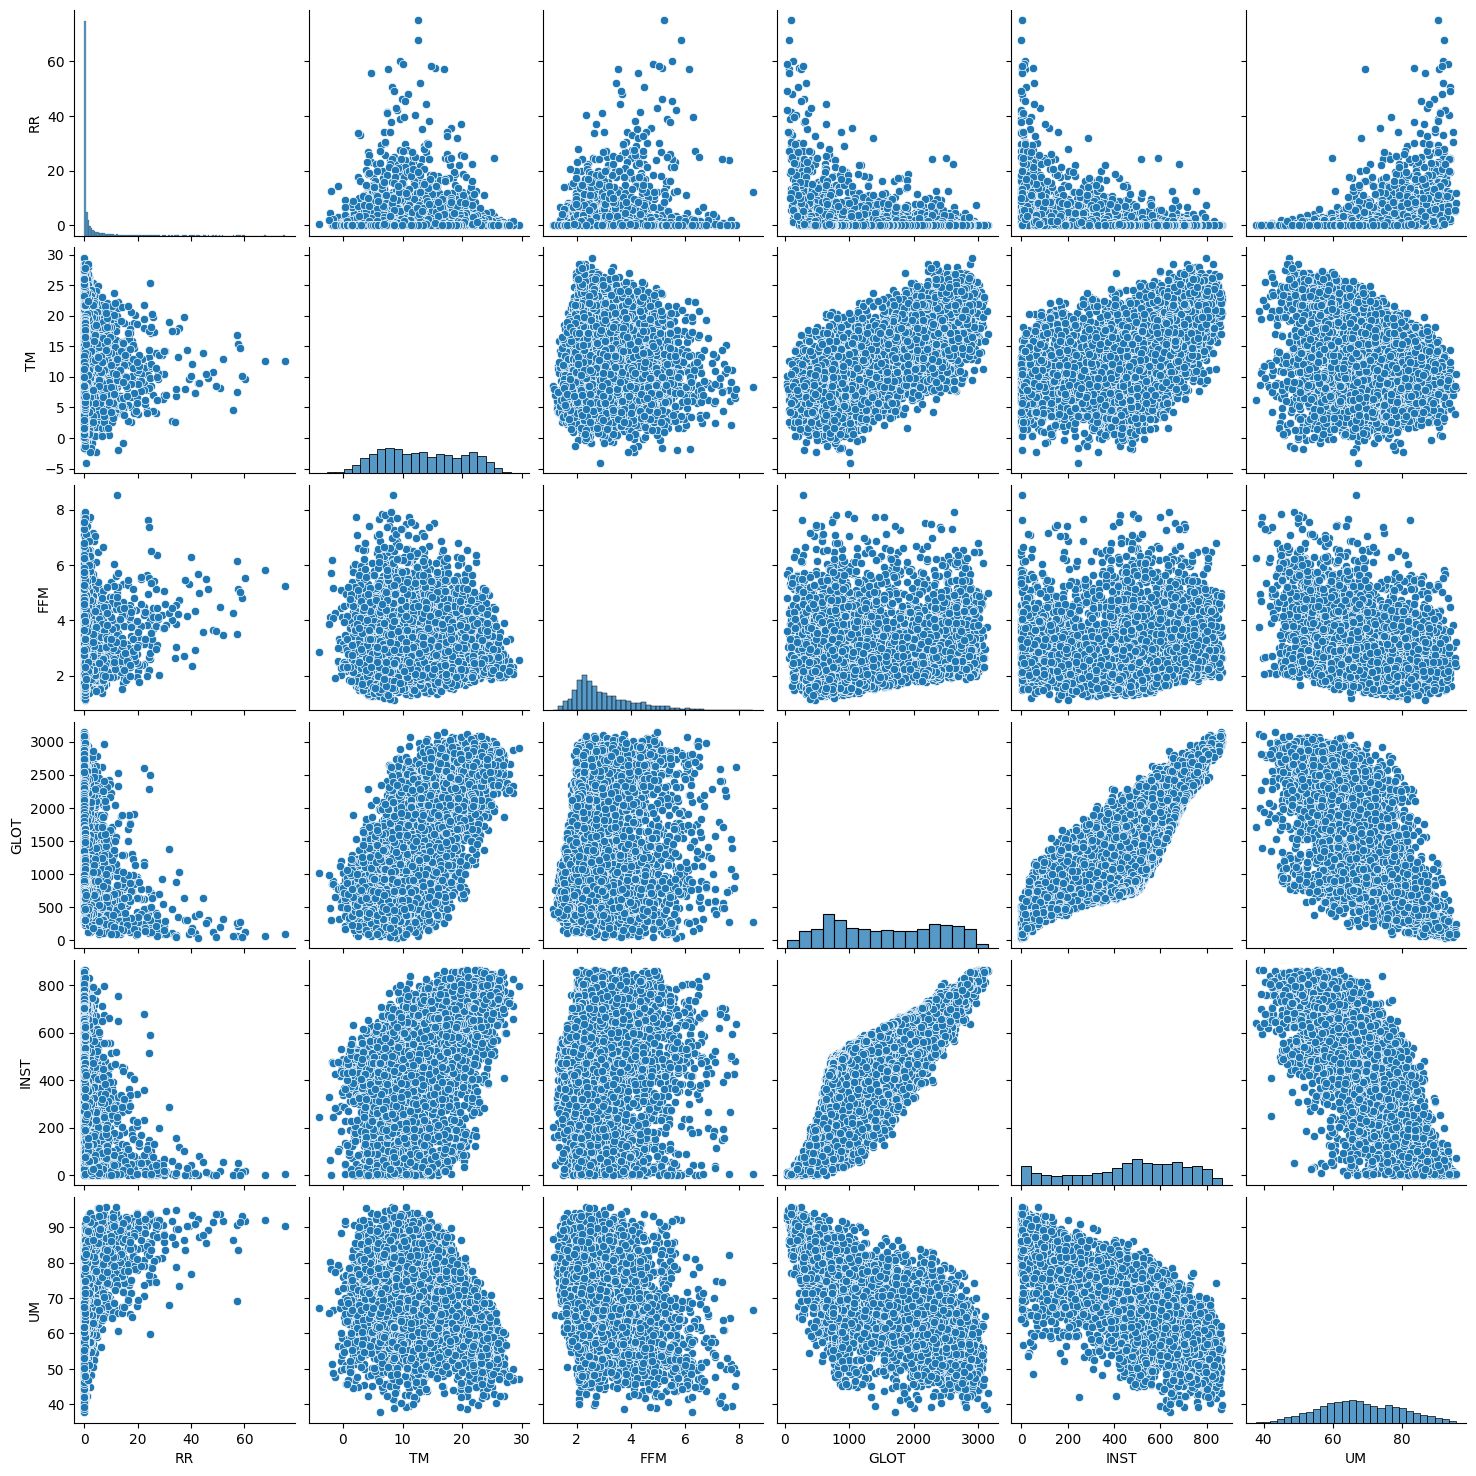

In [74]:
sns.pairplot(df_cs[['RR', 'TM', 'FFM', 'GLOT', 'INST', 'UM']])
plt.show()

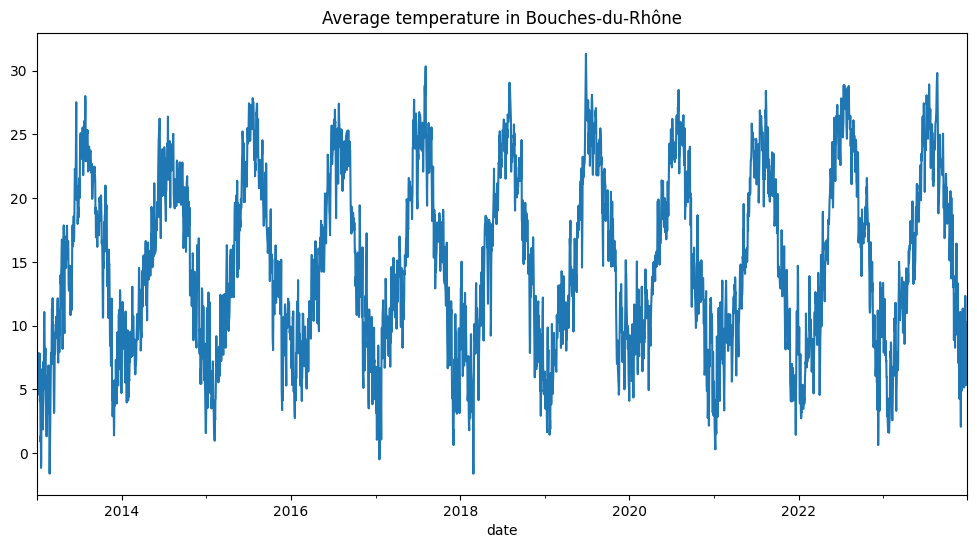

In [75]:
dept = 'Bouches-du-Rhône'

df_ts[df_ts['dept_name'] == dept]['TM'].plot(figsize=(12,6))
plt.title(f'Average temperature in {dept}')
plt.show()